In [47]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style('white')
sns.set(rc={'figure.figsize':(11, 4)})

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import AutoARIMA

from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
smape = MeanAbsolutePercentageError(symmetric = True)

import warnings
warnings.filterwarnings('ignore')

In [48]:
datafile = 'task_3.xlsx'
df = pd.read_excel(datafile, parse_dates=['date'], index_col='date')
df.head()

,balance_rub,balance_usd,exchange_rate,rate
date,,,,
2022-01-31,260000.000000,710.000000,75.88375,0.050
2022-02-28,253000.000000,688.000000,77.40477,0.056
2022-03-31,237045.000000,604.240000,104.08097,0.056
2022-04-30,233135.675000,573.715200,77.91456,0.068
2022-05-31,222272.710125,505.420896,64.77699,0.056


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2022-01-31 to 2024-12-31
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   balance_rub    27 non-null     float64
 1   balance_usd    27 non-null     float64
 2   exchange_rate  36 non-null     float64
 3   rate           27 non-null     float64
dtypes: float64(4)
memory usage: 1.4 KB


In [50]:
df.describe()

,balance_rub,balance_usd,exchange_rate,rate
count,27.000000,27.000000,36.000000,27.000000
mean,271642.062931,509.110156,82.779227,0.077778
std,37509.325465,90.686637,14.355421,0.022237
min,218456.800777,365.739575,57.269420,0.050000
25%,240361.497539,465.321810,72.079440,0.059000
50%,266390.149074,487.008369,89.855050,0.075000
75%,289150.138143,579.086507,95.329800,0.081000
max,346900.562386,710.000000,104.080970,0.126000


In [51]:
train = df[~df['balance_rub'].isna()]
test = df[df['balance_rub'].isna()]

In [52]:
train_rub = train['balance_rub']
test_rub = test['balance_rub']

In [53]:
train_rub.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 27 entries, 2022-01-31 to 2024-03-31
Series name: balance_rub
Non-Null Count  Dtype  
--------------  -----  
27 non-null     float64
dtypes: float64(1)
memory usage: 432.0 bytes


In [54]:
train_usd = train['balance_usd']
test_usd = test['balance_usd']

In [55]:
train_usd.head()

date
2022-01-31    710.000000
2022-02-28    688.000000
2022-03-31    604.240000
2022-04-30    573.715200
2022-05-31    505.420896
Name: balance_usd, dtype: float64

In [56]:
train_rate = train['rate']
test_rate = test['rate']

Установим индексы как периоды

In [57]:
train_rub.index = train_rub.index.to_period('M')
test_rub.index = test_rub.index.to_period('M')
train_usd.index = train_usd.index.to_period('M')
test_usd.index = test_usd.index.to_period('M')
train_rate.index = train_rate.index.to_period('M')
test_rate.index = test_rate.index.to_period('M')

Возьмем квартал (3 месяца) как пораметр для учета сезонной компонеты

In [58]:
forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="multiplicative", sp=3)),
    ("forecast", AutoARIMA(sp=3, suppress_warnings=True))
])

forecaster.fit(y=train_rub)

fh_test = np.arange(len(test_rub)) + 1
y_pred_rub = forecaster.predict(fh=fh_test)

forecaster.fit(y=train_usd)
y_pred_usd = forecaster.predict(fh=fh_test)

forecaster.fit(y=train_rate)
y_pred_rate = forecaster.predict(fh=fh_test)

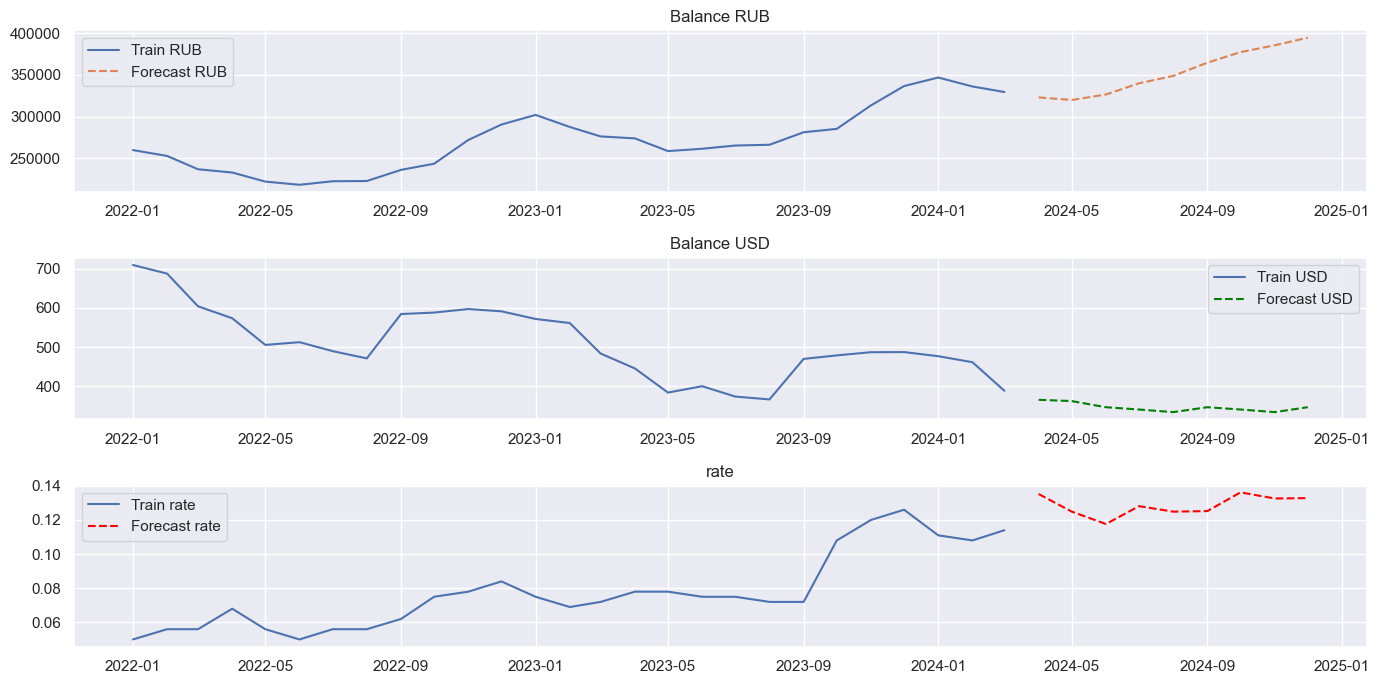

In [61]:
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
plt.plot(train_rub.index.to_timestamp(), train_rub, label='Train RUB')
plt.plot(test_rub.index.to_timestamp(), y_pred_rub, label='Forecast RUB', linestyle='--')
plt.title('Balance RUB')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(train_usd.index.to_timestamp(), train_usd, label='Train USD')
plt.plot(test_usd.index.to_timestamp(), y_pred_usd, label='Forecast USD', linestyle='--', color='green')
plt.title('Balance USD')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(train_rate.index.to_timestamp(), train_rate, label='Train rate')
plt.plot(test_rate.index.to_timestamp(), y_pred_rate, label='Forecast rate', linestyle='--', color='red')
plt.title('rate')
plt.legend()

plt.tight_layout()
plt.show()

In [31]:
y_pred_rub

2024-04    323080.000935
2024-05    320024.577679
2024-06    326576.186907
2024-07    340003.925532
2024-08    348872.739011
2024-09    364731.421009
2024-10    377328.806863
2024-11    385518.506383
2024-12    394618.850297
Freq: M, Name: balance_rub, dtype: float64

In [32]:
y_pred_usd

2024-04    364.813126
2024-05    361.550943
2024-06    345.823744
2024-07    339.930141
2024-08    333.257829
2024-09    345.823744
2024-10    339.930141
2024-11    333.257829
2024-12    345.823744
Freq: M, Name: balance_usd, dtype: float64

In [62]:
y_pred_rate

2024-04    0.135203
2024-05    0.124901
2024-06    0.117636
2024-07    0.128097
2024-08    0.124874
2024-09    0.125218
2024-10    0.136180
2024-11    0.132590
2024-12    0.132800
Freq: M, Name: rate, dtype: float64